In [1]:
# Load project functions
import crypto_monetary_base as cmb

In [2]:
import pandas as pd
import datetime, math
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set()
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.labelpad'] = 10
mpl.rc('text', usetex=True)
plt.style.use('ggplot')

from IPython.display import display

In [3]:
%load_ext version_information
%version_information pandas, matplotlib, seaborn

Software versions
Python 3.9.1 64bit [GCC 5.4.0 20160609]
IPython 7.19.0
OS Linux 5.8.0 0.bpo.2 amd64 x86_64 with glibc2.28
pandas 1.2.0
matplotlib 3.3.3
seaborn 0.11.1
Sun Jan 10 20:12:20 2021 EST

## Supply Curve Calculation

### Some constants

In [4]:
COIN_SYMBOL = 'SMH'
LAYER_TIME = 5 # in minutes
LAYERS_PER_YEAR = 365.25 * 24 * 60 / LAYER_TIME
PREMINE_AMOUNT = 1_500_000

# TODO: make this math cleaner, turn this into a function
ISSUANCE_PER_YEAR_PLAN1 = [
    800_000, # year 0
    700_000, # year 1
    600_000, # year 2
    500_000, # year 3
    400_000, # year 4
    300_000, # year 5
    200_000, # year 6
    200_000, # year 7
    200_000, # year 8
    100_000, # year 9
    # 4M total first ten years
    
     25_000, # year 10
     25_000, # year 11
     25_000, # year 12
     25_000, # year 13
     25_000, # year 14
     25_000, # year 15
     25_000, # year 16
     25_000, # year 17
     25_000, # year 18
     25_000, # year 19
    # 250k total second ten years
    
     25_000, # year 20
     25_000, # year 21
     25_000, # year 22
     25_000, # year 23
     25_000, # year 24
     25_000, # year 25
     25_000, # year 26
     25_000, # year 27
     25_000, # year 28
     25_000, # year 19
    # 250k total third ten years
    
    # 4.5M total issuance + 1.5M premine = 6M total
]

ISSUANCE_PER_YEAR_PLAN2 = [
    900_000, # year 0
    800_000, # year 1
    700_000, # year 2
    600_000, # year 3
    500_000, # year 4
    400_000, # year 5
    300_000, # year 6
    200_000, # year 7
     75_000, # year 8
     25_000, # year 9
    # 4.5M total first ten years
        
    # 4.5M total issuance + 1.5M premine = 6M total
]

In [5]:
LAYERS_PER_YEAR

105192.0

In [6]:
def smh_layer_supply_curve(
    num_layers,
    output_granularity=10_000,
    ):
    out = [
        # Layer num,
        # Total supply - Plan1,
        # Total supply - Plan2,
    ]
    
    y_1 = PREMINE_AMOUNT
    y_2 = PREMINE_AMOUNT
    layer_reward_plan1 = 0
    layer_reward_plan2 = 0
    for layer in tqdm(range(1, num_layers+1)):
        # Adjust layer reward once per year
        if (layer-1) % math.floor(LAYERS_PER_YEAR) == 0:
            current_year = math.floor((layer-1)/LAYERS_PER_YEAR) # 0-indexed

            # If there is no scheduled issuance for this year (i.e., we are beyond the end of
            # the schedule), then set issuance to zero
            year_issuance_plan1 = year_issuance_plan2 = 0
            
            ## PLAN 1: 30-year issuance model
            
            if current_year < len(ISSUANCE_PER_YEAR_PLAN1):
                year_issuance_plan1 = ISSUANCE_PER_YEAR_PLAN1[current_year]
            layer_reward_plan1 = year_issuance_plan1/LAYERS_PER_YEAR
            print(f"Adjust plan1 layer reward for year {current_year} (total issuance {year_issuance_plan1}) to {layer_reward_plan1}")
            
            ## PLAN 2: 10-year issuance model

            if current_year < len(ISSUANCE_PER_YEAR_PLAN2):
                year_issuance_plan2 = ISSUANCE_PER_YEAR_PLAN2[current_year]
            layer_reward_plan2 = year_issuance_plan2/LAYERS_PER_YEAR
            print(f"Adjust plan2 layer reward for year {current_year} (total issuance {year_issuance_plan2}) to {layer_reward_plan2}")
            
        y_1 += layer_reward_plan1
        y_2 += layer_reward_plan2
        
        if (layer-1) % output_granularity == 0:
            out.append([layer, y_1, y_2])

    return out

In [7]:
def datetime_smh_supply_curve(
    start_date,
    layer_time,
    layer_supply,
    output_granularity=10_000,
    ):
    df = pd.DataFrame(
        layer_supply, columns=['layer', 'plan1', 'plan2']
    )
    df['plan1_pct'] = (
        df['plan1'] / df['plan1'].values[-1]
        * 100
    )
    df['plan2_pct'] = (
        df['plan2'] / df['plan2'].values[-1]
        * 100
    )
    df['date'] = pd.date_range(
        start=start_date,
        freq=layer_time * output_granularity,
        periods=len(df)
    )
    return df

In [8]:
def plot_smh_supply_curve(
    supply,
    coin_name='SMH',
    plot_pct=False,
    max_size=10_000,
    out_name='',
    ):
    max_size = min((max_size, len(supply)))
    step_size = int(len(supply) / max_size)
    dates = mpl.dates.date2num(supply.date.values[::step_size])
    
    # Plan1
    if plot_pct:
        values = supply.plan1_pct.values[::step_size]
    else:
        values = supply.plan1.values[::step_size]
    plt.plot_date(
        dates,
        values,
        fmt='--',
        lw=4,
        label='plan1',
    )
    
    # Plan2
    if plot_pct:
        values = supply.plan2_pct.values[::step_size]
    else:
        values = supply.plan2.values[::step_size]
    plt.plot_date(
        dates,
        values,
        fmt='-',
        lw=4,
        label='plan2',
        color='orange',
    )
    
    plt.title(
        fr'$\textbf{{{coin_name}}}$ Monetary Base',
        y=1.05
    )
    plt.legend()
    
    ax = plt.gca()
    if plot_pct:
        ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
    
    if not out_name:
        out_name = coin_name
    plt.savefig(
        f'../charts/{out_name}.png',
        bbox_inches='tight',
        dpi=300
    )
    return plt

In [9]:
start_date = datetime.date(2021, 7, 1)
end_date = datetime.date(2140, 10, 7)
layer_time = datetime.timedelta(minutes=LAYER_TIME)

num_layers = int(
    ((end_date - start_date).days * 24 * 3600)
    / layer_time.seconds
)

layer_supply = smh_layer_supply_curve(
    num_layers=num_layers,
)

supply = datetime_smh_supply_curve(
    start_date=start_date,
    layer_time=layer_time,
    layer_supply=layer_supply,
)

  0%|          | 0/12545856 [00:00<?, ?it/s]

Adjust plan1 layer reward for year 0 (total issuance 800000) to 7.605141075366948
Adjust plan2 layer reward for year 0 (total issuance 900000) to 8.555783709787816
Adjust plan1 layer reward for year 1 (total issuance 700000) to 6.65449844094608
Adjust plan2 layer reward for year 1 (total issuance 800000) to 7.605141075366948
Adjust plan1 layer reward for year 2 (total issuance 600000) to 5.703855806525211
Adjust plan2 layer reward for year 2 (total issuance 700000) to 6.65449844094608
Adjust plan1 layer reward for year 3 (total issuance 500000) to 4.753213172104343
Adjust plan2 layer reward for year 3 (total issuance 600000) to 5.703855806525211
Adjust plan1 layer reward for year 4 (total issuance 400000) to 3.802570537683474
Adjust plan2 layer reward for year 4 (total issuance 500000) to 4.753213172104343
Adjust plan1 layer reward for year 5 (total issuance 300000) to 2.8519279032626055
Adjust plan2 layer reward for year 5 (total issuance 400000) to 3.802570537683474
Adjust plan1 laye

Adjust plan1 layer reward for year 60 (total issuance 0) to 0.0
Adjust plan2 layer reward for year 60 (total issuance 0) to 0.0
Adjust plan1 layer reward for year 61 (total issuance 0) to 0.0
Adjust plan2 layer reward for year 61 (total issuance 0) to 0.0
Adjust plan1 layer reward for year 62 (total issuance 0) to 0.0
Adjust plan2 layer reward for year 62 (total issuance 0) to 0.0
Adjust plan1 layer reward for year 63 (total issuance 0) to 0.0
Adjust plan2 layer reward for year 63 (total issuance 0) to 0.0
Adjust plan1 layer reward for year 64 (total issuance 0) to 0.0
Adjust plan2 layer reward for year 64 (total issuance 0) to 0.0
Adjust plan1 layer reward for year 65 (total issuance 0) to 0.0
Adjust plan2 layer reward for year 65 (total issuance 0) to 0.0
Adjust plan1 layer reward for year 66 (total issuance 0) to 0.0
Adjust plan2 layer reward for year 66 (total issuance 0) to 0.0
Adjust plan1 layer reward for year 67 (total issuance 0) to 0.0
Adjust plan2 layer reward for year 67 (t

In [10]:
display(supply.head())
display(supply.tail())

,layer,plan1,plan2,plan1_pct,plan2_pct,date
0,1,1.500008e+06,1.500009e+06,25.000127,25.000143,2021-07-01 00:00:00
1,10001,1.576059e+06,1.585566e+06,26.267650,26.426107,2021-08-04 17:20:00
2,20001,1.652110e+06,1.671124e+06,27.535174,27.852070,2021-09-08 10:40:00
3,30001,1.728162e+06,1.756682e+06,28.802697,29.278034,2021-10-13 04:00:00
4,40001,1.804213e+06,1.842240e+06,30.070221,30.703998,2021-11-16 21:20:00


,layer,plan1,plan2,plan1_pct,plan2_pct,date
1250,12500001,6.000000e+06,6.000000e+06,100.0,100.0,2140-04-30 18:40:00
1251,12510001,6.000000e+06,6.000000e+06,100.0,100.0,2140-06-04 12:00:00
1252,12520001,6.000000e+06,6.000000e+06,100.0,100.0,2140-07-09 05:20:00
1253,12530001,6.000000e+06,6.000000e+06,100.0,100.0,2140-08-12 22:40:00
1254,12540001,6.000000e+06,6.000000e+06,100.0,100.0,2140-09-16 16:00:00


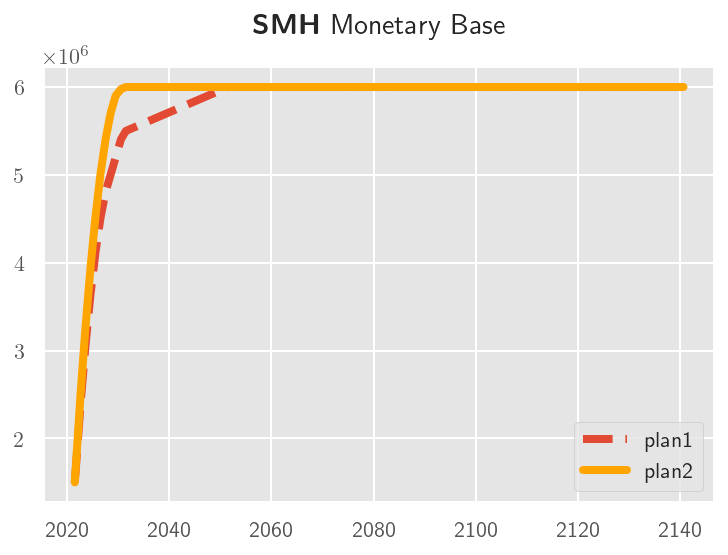

In [11]:
plot_smh_supply_curve(supply);

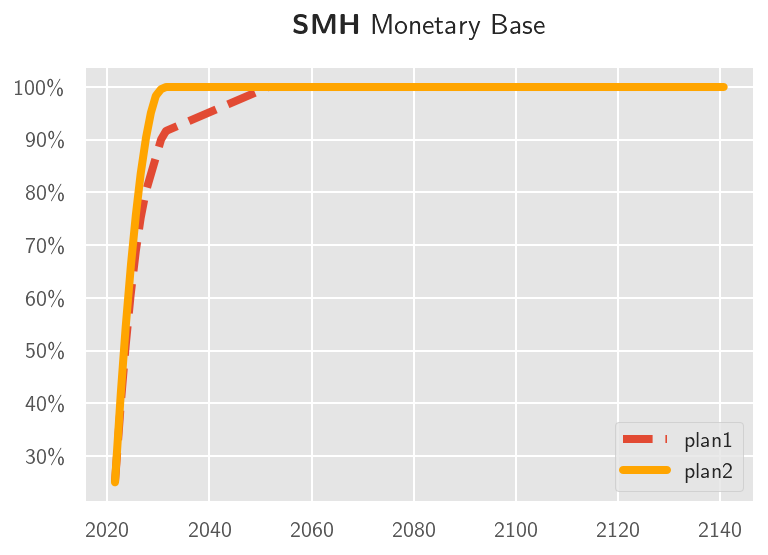

In [12]:
plot_smh_supply_curve(supply, plot_pct=True, out_name='SMH_pct');

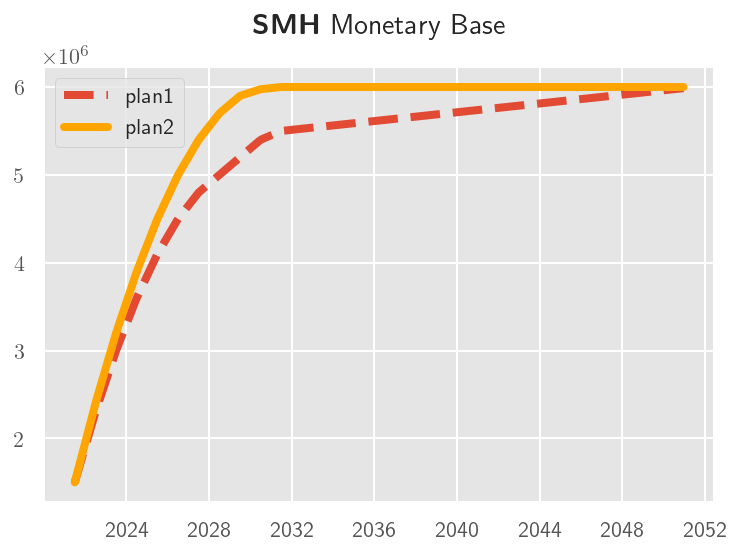

In [13]:
mask = supply.date < datetime.datetime(2051, 1, 1)
plot_smh_supply_curve(supply[mask], out_name='SMH_zoom');

## Standardize Time Series

In [14]:
weekly_supply = cmb.transform_supply(supply, COIN_SYMBOL, freq='weekly')

display(weekly_supply.head())
display(weekly_supply.tail())

Wrote 1255 lines to file ../output-data/SMH_weekly.csv


,coin,layer,plan1,plan2,plan1_pct,plan2_pct,date
0,SMH,1,1.500008e+06,1.500009e+06,25.000127,25.000143,2021-07-01
1,SMH,10001,1.576059e+06,1.585566e+06,26.267650,26.426107,2021-08-01
2,SMH,20001,1.652110e+06,1.671124e+06,27.535174,27.852070,2021-09-01
3,SMH,30001,1.728162e+06,1.756682e+06,28.802697,29.278034,2021-10-01
4,SMH,40001,1.804213e+06,1.842240e+06,30.070221,30.703998,2021-11-01


,coin,layer,plan1,plan2,plan1_pct,plan2_pct,date
1250,SMH,12500001,6.000000e+06,6.000000e+06,100.0,100.0,2140-04-01
1251,SMH,12510001,6.000000e+06,6.000000e+06,100.0,100.0,2140-06-01
1252,SMH,12520001,6.000000e+06,6.000000e+06,100.0,100.0,2140-07-01
1253,SMH,12530001,6.000000e+06,6.000000e+06,100.0,100.0,2140-08-01
1254,SMH,12540001,6.000000e+06,6.000000e+06,100.0,100.0,2140-09-01


In [15]:
monthly_supply = cmb.transform_supply(supply, COIN_SYMBOL, freq='monthly')

display(monthly_supply.head())
display(monthly_supply.tail())

Wrote 1255 lines to file ../output-data/SMH_monthly.csv


,coin,layer,plan1,plan2,plan1_pct,plan2_pct,date
0,SMH,1,1.500008e+06,1.500009e+06,25.000127,25.000143,2021-07-01
1,SMH,10001,1.576059e+06,1.585566e+06,26.267650,26.426107,2021-08-01
2,SMH,20001,1.652110e+06,1.671124e+06,27.535174,27.852070,2021-09-01
3,SMH,30001,1.728162e+06,1.756682e+06,28.802697,29.278034,2021-10-01
4,SMH,40001,1.804213e+06,1.842240e+06,30.070221,30.703998,2021-11-01


,coin,layer,plan1,plan2,plan1_pct,plan2_pct,date
1250,SMH,12500001,6.000000e+06,6.000000e+06,100.0,100.0,2140-04-01
1251,SMH,12510001,6.000000e+06,6.000000e+06,100.0,100.0,2140-06-01
1252,SMH,12520001,6.000000e+06,6.000000e+06,100.0,100.0,2140-07-01
1253,SMH,12530001,6.000000e+06,6.000000e+06,100.0,100.0,2140-08-01
1254,SMH,12540001,6.000000e+06,6.000000e+06,100.0,100.0,2140-09-01


In [16]:
yearly_supply = cmb.transform_supply(supply, COIN_SYMBOL, freq='yearly')

display(yearly_supply.head())
display(yearly_supply.tail())

Wrote 120 lines to file ../output-data/SMH_yearly.csv


,coin,layer,plan1,plan2,plan1_pct,plan2_pct,date
0,SMH,1,1.500008e+06,1.500009e+06,25.000127,25.000143,2021-07-01
1,SMH,60001,1.956316e+06,2.013356e+06,32.605268,33.555926,2022-01-01
2,SMH,160001,2.664726e+06,2.816830e+06,44.412107,46.947170,2023-01-01
3,SMH,270001,3.340047e+06,3.596721e+06,55.667446,59.945354,2024-01-01
4,SMH,370001,3.858694e+06,4.210432e+06,64.311560,70.173873,2025-01-01


,coin,layer,plan1,plan2,plan1_pct,plan2_pct,date
115,SMH,12050001,6.000000e+06,6.000000e+06,100.0,100.0,2136-01-01
116,SMH,12150001,6.000000e+06,6.000000e+06,100.0,100.0,2137-01-01
117,SMH,12260001,6.000000e+06,6.000000e+06,100.0,100.0,2138-01-01
118,SMH,12370001,6.000000e+06,6.000000e+06,100.0,100.0,2139-02-01
119,SMH,12470001,6.000000e+06,6.000000e+06,100.0,100.0,2140-01-01
